In [90]:
#若下方缺少包可以取消注释在jupyter下载
#!pip install pandas matplotlib cartopy

In [96]:
#1. Global Earthquakes
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1.1 数据读取与处理

# 读取文件
file_path = 'usgs_earthquakes.csv'
df = pd.read_csv(file_path)

# 处理时间列，提取年份
df['time'] = pd.to_datetime(df['time'])
df['year'] = df['time'].dt.year

# 筛选 2014 年的数据 
df_2014 = df[df['year'] == 2014].copy()

# 筛选震级最大的前 50 个
# sort_values: 按 'mag' 降序排列
# head(50): 取前 50 行
df_top50 = df_2014.sort_values(by='mag', ascending=False).head(50)

print(f"筛选出的2014年Top 50地震，最大震级: {df_top50['mag'].max()}")


筛选出的2014年Top 50地震，最大震级: 8.2


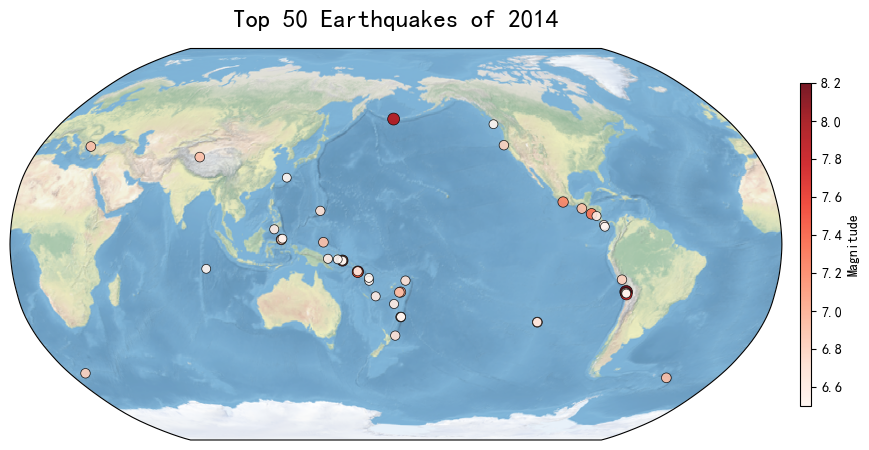

In [97]:
# 1.2 地图绘制

# 创建画布
plt.figure(figsize=(12, 7))

# 太平洋居中
# central_longitude=180 表示以 180度经线 (太平洋中部) 为中心
# 这样美洲会跑到右边，亚洲/澳洲在左边
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

# 森林/沙漠地形颜色
# stock_img() 会添加一张低分辨率的地球卫星照片作为背景
# 这样陆地上就会显示出绿色的森林、黄褐色的沙漠等纹理
ax.stock_img()


# 添加海岸线 (为了让轮廓更清晰)；但是不使用更接近作业要求
#ax.coastlines(linewidth=0.8, color='black')

# 绘制散点
scatter = ax.scatter(
    x=df_top50['longitude'], 
    y=df_top50['latitude'], 
    # 大小设置: (震级^3)*0.15，让大地震更明显;可提供调整最后一个参数来调整点的大小
    s=df_top50['mag'] ** 3 * 0.15,  
    c=df_top50['mag'],           # 颜色随震级变化
    cmap='Reds',                 # 红色系 (在卫星底图上红色比较显眼)
    alpha=0.9,                   # 透明度
    edgecolor='black',          
    linewidth=0.5,
    
    # 数据本身是经纬度 (PlateCarree)，需要转换到我们设定的投影上
    transform=ccrs.PlateCarree() 
)

# 3. 图饰与色标 (Decoration)

plt.title('Top 50 Earthquakes of 2014', fontsize=18, pad=15)

# 添加色标 (右侧)
cbar = plt.colorbar(scatter, orientation='vertical', pad=0.02, shrink=0.6, aspect=30)
cbar.set_label('Magnitude')

plt.show()

In [98]:
#2. Explore a netCDF dataset
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import cartopy.crs as ccrs  # 导入 cartopy 投影模块
import cartopy.feature as cfeature  # 导入地图特征模块
from matplotlib.offsetbox import AnchoredText # 用于添加文本框

# 字体设置
# 设置中文字体，防止中文显示为方块
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Heiti TC', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False 


# 数据加载与清洗 

VARIABLE_NAME = 'flux'
datasets_to_merge = []

# 1.1 加载 v1 数据 (2010-2012)
file_pattern_v1 = "CMSFluxFire_*_v1.nc4"
file_list_v1 = sorted(glob.glob(file_pattern_v1))
fixed_v1_datasets = []

for file_path in file_list_v1:
    try:
        ds_single_v1 = xr.open_dataset(file_path, decode_times=False)
        # 修复时间
        if 'months since' in ds_single_v1.time.attrs.get('units', ''):
            time_units = ds_single_v1.time.attrs['units']
            start_date_str = time_units.split('since')[-1].strip().split('T')[0]
            new_times = pd.date_range(start=start_date_str, periods=len(ds_single_v1.time), freq='MS') + pd.DateOffset(days=14)
            ds_single_v1 = ds_single_v1.assign_coords(time=new_times)
            fixed_v1_datasets.append(ds_single_v1)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

if fixed_v1_datasets:
    ds_v1 = xr.concat(fixed_v1_datasets, dim='time')
    if 'Fire' in ds_v1.data_vars:
        ds_v1 = ds_v1.rename({'Fire': 'flux'})
        datasets_to_merge.append(ds_v1['flux'])

# 1.2 加载 v2 数据 (2013-2016)
file_pattern_v2 = "CMS_Flux_Fire_*_v2.nc"
file_list_v2 = sorted(glob.glob(file_pattern_v2))
fixed_v2_datasets = []

for file_path in file_list_v2:
    try:
        ds_single_v2 = xr.open_dataset(file_path, decode_times=False)
        if 'months since' in ds_single_v2.time.attrs.get('units', ''):
            time_units = ds_single_v2.time.attrs['units']
            start_date_str = time_units.split('since')[-1].strip().split('T')[0]
            new_times = pd.date_range(start=start_date_str, periods=len(ds_single_v2.time), freq='MS') + pd.DateOffset(days=14)
            ds_single_v2 = ds_single_v2.assign_coords(time=new_times)
            fixed_v2_datasets.append(ds_single_v2)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

if fixed_v2_datasets:
    ds_v2 = xr.concat(fixed_v2_datasets, dim='time')
    if 'flux' in ds_v2.data_vars:
        datasets_to_merge.append(ds_v2['flux'])

# 1.3 合并数据
if datasets_to_merge:
    ds_combined = xr.concat(datasets_to_merge, dim='time').sortby('time').to_dataset()
    ds_combined = ds_combined.fillna(0.0) # 填充缺失值
    print("数据加载完成。")
else:
    raise ValueError("未找到数据，请检查文件路径。")

# 1.4 计算时间平均值用于绘图 (因为我们要画 2D 地图，需要把 Time 维平均掉)
# 可以选择特定时间，例如: flux_2d = ds_combined['flux'].sel(time='2015-01-15', method='nearest')
flux_mean = ds_combined['flux'].mean(dim='time')


数据加载完成。


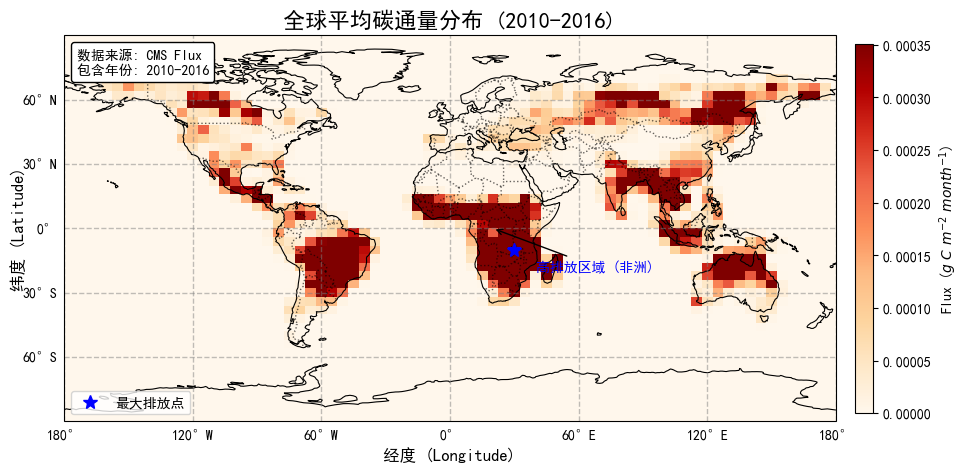

In [94]:
# 2.1 绘制全球地图 (Global Map)

# 创建画布，设置投影为 PlateCarree (等经纬度投影)
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

#使用 pcolormesh 绘制数据
# transform=ccrs.PlateCarree() 告诉 cartopy 数据的坐标系是经纬度
plot = flux_mean.plot.pcolormesh(
    ax=ax, 
    transform=ccrs.PlateCarree(),
    cmap='OrRd',  # 颜色表：红橙色适合表示火/通量
    add_colorbar=False, # 先不自动添加，后面手动添加以满足要求
    vmin=0, vmax=flux_mean.quantile(0.95) # 限制最大值以避免极值影响显示
)

#设置标题
ax.set_title('全球平均碳通量分布 (2010-2016)', fontsize=16)

#添加地图特征
ax.add_feature(cfeature.COASTLINE, linewidth=0.8) # 海岸线
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.6) # 国界
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3) # 海洋掩膜

#添加网格线
# draw_labels=True 会自动在地图边缘添加经纬度数值
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False # 关闭顶部标签
gl.right_labels = False # 关闭右侧标签

#只有在 PlateCarree 下，set_xlabel 才容易生效，
# 但通常网格线标签(gridlines labels)已经充当了 ticks。
# 这里为了满足题目 "x label" 的要求，我们在轴外侧添加文本。
ax.text(0.5, -0.1, '经度 (Longitude)', transform=ax.transAxes, ha='center', fontsize=12)
ax.text(-0.07, 0.5, '纬度 (Latitude)', transform=ax.transAxes, va='center', rotation='vertical', fontsize=12)

#添加色标
cbar = plt.colorbar(plot, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)
cbar.set_label('Flux ($g\ C\ m^{-2}\ month^{-1}$)') # 色标标签

#添加注释
# 指向非洲中部的高值区
ax.annotate('高排放区域 (非洲)', xy=(20, 0), xytext=(40, -20),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=10, color='blue', transform=ccrs.PlateCarree())

#添加图例
# 对于连续数据的热力图，Colorbar 就是图例。但为了满足 "Legend" 要求，
# 我们可以手动添加一个代理图例，比如标记出的最大值点。
# 找到最大值位置
max_val = flux_mean.max()
max_loc = flux_mean.where(flux_mean == max_val, drop=True)
if max_loc.size > 0:
    max_lat = max_loc.lat.values[0]
    max_lon = max_loc.lon.values[0]
    # 画一个点
    ax.plot(max_lon, max_lat, 'b*', markersize=10, transform=ccrs.PlateCarree(), label='最大排放点')
    ax.legend(loc='lower left') # 显示图例

#添加文本框
text_box = AnchoredText("数据来源: CMS Flux\n包含年份: 2010-2016", loc=2, prop=dict(size=10), frameon=True)
text_box.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(text_box)

plt.show()



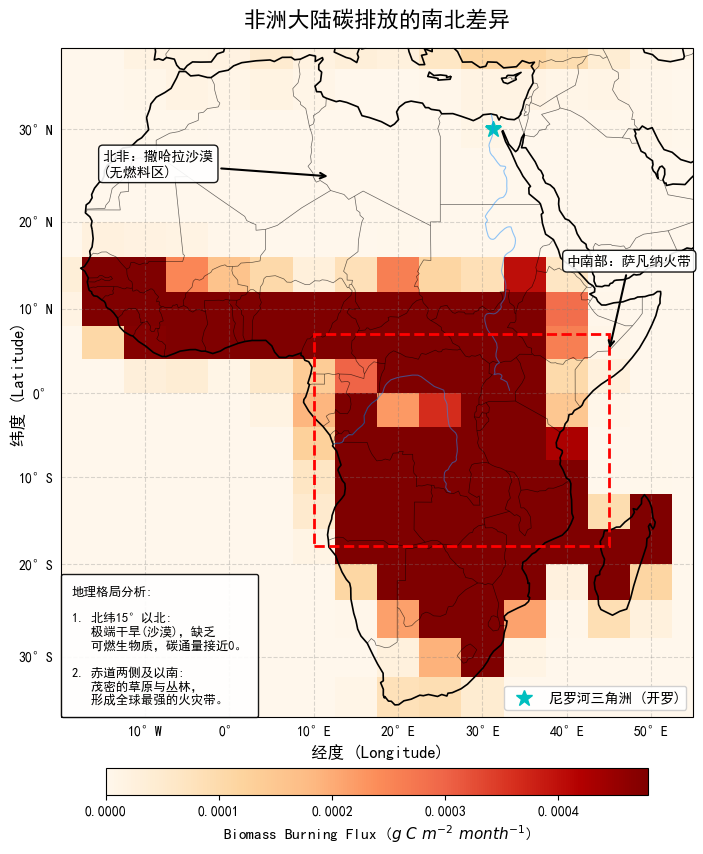

In [95]:
#2.2 绘制区域地图

# 1.使用墨卡托投影 (Mercator)
# 非洲跨越南北半球，墨卡托投影能较好地保持形状
fig = plt.figure(figsize=(10, 11)) # 调整为长方形，适应非洲大陆形状
ax = plt.axes(projection=ccrs.Mercator())

# 设置显示范围：全非洲
# [西经20, 东经55, 南纬36, 北纬38] -> 完整覆盖从摩洛哥到南非
extent = [-20, 55, -36, 38] 
ax.set_extent(extent, crs=ccrs.PlateCarree())

# 2.绘图
#采用上图相同绘图颜色策略，保证一致性
plot = flux_mean.plot.pcolormesh(
    ax=ax, 
    transform=ccrs.PlateCarree(),
    cmap='OrRd', 
    add_colorbar=False, 
    vmin=0, 
    vmax=flux_mean.quantile(0.96) # 稍微放宽上限，让燃烧带更亮
)

# 3.标题
ax.set_title('非洲大陆碳排放的南北差异', fontsize=16, pad=15)

# 4.地图特征
ax.add_feature(cfeature.COASTLINE, linewidth=1.2, zorder=5) 
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, alpha=0.6, color='black', zorder=5) # 黑色国界

ax.add_feature(cfeature.RIVERS, color='dodgerblue', alpha=0.5, linewidth=0.8, zorder=5) 

# 5.网格线
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.3, color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# 6.轴标签
ax.text(0.5, -0.06, '经度 (Longitude)', transform=ax.transAxes, ha='center', fontsize=12)
ax.text(-0.08, 0.5, '纬度 (Latitude)', transform=ax.transAxes, va='center', rotation='vertical', fontsize=12)

# 7.色标
cbar = plt.colorbar(plot, ax=ax, orientation='horizontal', pad=0.06, shrink=0.7)
cbar.set_label('Biomass Burning Flux ($g\ C\ m^{-2}\ month^{-1}$)', fontsize=11)

#8.标注南北差异

# A. 标注北部：撒哈拉沙漠 (无排放区)
# 解释：因为没有植被(燃料)，所以没有火灾
ax.annotate('北非：撒哈拉沙漠\n(无燃料区)', xy=(12, 25), xytext=(-15, 25),
             arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
             fontsize=10, fontweight='bold', color='black',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9, ec='black'),
             transform=ccrs.PlateCarree(), zorder=10)

# B.标注中部/南部：稀树草原 (高排放区)
# 解释：大量的草本植物 + 干湿季交替 = 强烈火灾
ax.annotate('中南部：萨凡纳火带', xy=(45, 5), xytext=(40, 15),
             arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5), # 黑色箭头
             fontsize=10, fontweight='bold', color='black', # 黑色文字
             bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9, ec='black'), # 白底黑框
             transform=ccrs.PlateCarree(), zorder=10)

#C. 非洲萨凡纳火带标注
# 范围大约是: 经度 10~40, 纬度 -15~5 (根据数据实际分布调整)
rect = mpatches.Rectangle(
    (10, -18), 35, 25,  # (x, y), width, height
    fill=False,         # 不填充颜色，只画框
    edgecolor='red',    # 边框
    linewidth=2, 
    linestyle='--',     # 虚线
    transform=ccrs.PlateCarree(), 
    zorder=6
)
ax.add_patch(rect)
# 9.图例
# 标记尼罗河三角洲作为地理参考
ax.plot(31.2, 30.0, 'c*', markersize=12, transform=ccrs.PlateCarree(), label='尼罗河三角洲 (开罗)')
ax.legend(loc='lower right', framealpha=0.9, facecolor='white')

# 10.文本框
text_content = (
    "地理格局分析:\n\n"
    "1. 北纬15°以北:\n"
    "   极端干旱(沙漠)，缺乏\n"
    "   可燃生物质，碳通量接近0。\n\n"
    "2. 赤道两侧及以南:\n"
    "   茂密的草原与丛林，\n"
    "   形成全球最强的火灾带。"
)
# 放在左下角的大西洋上
text_box = AnchoredText(text_content, loc=3, prop=dict(size=9), frameon=True)
text_box.patch.set_boxstyle("round,pad=0.5,rounding_size=0.2")
text_box.patch.set_alpha(0.9)
ax.add_artist(text_box)

plt.show()